# Gaussian Mixture Model

Implementing Expectation Maximization(EM) Algorithm for estimating Parameters of N-Dimensional Gaussian Mixture Model.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import random
import os

from IPython.display import display, Math, Latex, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### N-Dimensional Gaussian Distribution
$f(x)=\frac{1}{\sqrt{(2 \pi)^{k} \operatorname{det} \Sigma}} \exp \left(-\frac{1}{2}(x-\mu)^{T} \Sigma^{-1}(x-\mu)\right)$

### Expectation-Maximization Algorithm
**Steps:**
1. Initialise $μ_k$ , covariances $\sum_k$ and mixing coefficients $\pi_k$ , and evaluate the initial value of the Log Likelihood.
2. Calculate Posterior Probabilities.\
\begin{equation}
\gamma\left(z_{n k}\right)=\frac{\pi_{k} \mathcal{N}\left(\mathbf{x}_{n} \mid {\mu}_{k}, {\Sigma}_{k}\right)}{\sum_{j=1}^{K} \pi_{j} \mathcal{N}\left(\mathbf{x}_{n} \mid {\mu}_{j}, {\Sigma}_{j}\right)}
\end{equation}
3. Estimating Parameters from Posterior Probabilities.\
$$
\begin{aligned}
{\mu}_{k}^{\text {new }} &=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right) \mathbf{x}_{n} \\
{\Sigma}_{k}^{\text {new }} &=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right)\left(\mathbf{x}_{n}-{\mu}_{k}^{\text {new }}\right)\left(\mathbf{x}_{n}-{\mu}_{k}^{\text {new }}\right)^{\mathrm{T}} \\
\pi_{k}^{\text {new }} &=\frac{N_{k}}{N}
\end{aligned}
$$
where
$$
N_{k}=\sum_{n=1}^{N} \gamma\left(z_{n k}\right)
$$
4. Stopping Condition \
\begin{align}
\mu_{k+1} = {\mu}_{k}^{\text {new }}\\
\Sigma_{k+1} = {\Sigma}_{k}^{\text {new }}\\
\pi_{k+1} = \pi_{k}^{\text {new }}
\end{align}

\begin{equation}
|| \mu_{k+1} - \mu_{k}||_p + || \Sigma_{k+1} - \Sigma_{k}||_p + ||\pi_{k+1} - \pi_k||_p< \epsilon
\end{equation}

---

### Notations:
1. **N:** Total No.of Data Points
2. **D:** No.fo Dimensions
3. **k:** No.of Gaussian Mixtures
4. **X:** Input Data
5. **Z:** Latent Variable
6. **Mean:** Mean of k-Gaussian Mixtures
7. **CoVariance:** CoVariance of k-Gaussian Mixtures
8. **p:** Array containing $\pi_{k}$'s
9. **Px:** Matrix containing $p_{nk}$
9. **R:** Matrix containing $\gamma_{nk}$'s

---

**Note:**
1. Tried to Reinitialize all Parameters is **Nan** is encountered.
2. Tried to handle Zero Determinent Cases of CoVariance Matrix by adding a Identity Matrix of Determinent $10^{-2k}$.

In [2]:
class GaussianMixtureModel:
    def __init__(self):
        self.N = None
        self.D = None
        self.k = None
        self.X = None
        self.Z = None
        self.Mean = None
        self.CoVariance = None
        self.p = None
        self.Px = None
        self.R = None
        
        
    def Gaussian(self,x,mu,cov):
        # Calculates pdf of N-dimensional Gaussian Distribution
        """
        x: Data Point
        mu: Mean of Gaussian Distribution
        cov: CoVariance Matrix of Gaussian Distribution
        """
        f = 1/np.sqrt(pow(2*np.pi,self.D) * np.linalg.det(cov))
        p = -0.5*((x-mu).T @ np.linalg.inv(cov) @ (x-mu))
        return f*np.exp(p)
        
        
    def PosteriorProbability(self):
        # Calculates Posterior Probability or Responsibility
        self.R = np.zeros((self.N,self.k))
        self.Px = np.zeros((self.N,self.k))
        
        for i in range(self.N):
            for j in range(self.k):
                # Handling Cases for Zero Determinent CoVariance Matrix
                if np.linalg.det(self.CoVariance[j]) == 0:
                    self.CoVariance[j] += (0.01 * np.identity(self.D))
                self.R[i][j] = self.p[j] * self.Gaussian(self.X[i],self.Mean[j],self.CoVariance[j])
                self.Px[i][j] = self.R[i][j]
                
            self.R[i,:] = (self.R[i,:])/np.sum(self.R[i,:])
            

    def EMAlgorithm(self):
        Old_Mean = self.Mean
        Old_CoVariance = self.CoVariance
        Old_p = self.p
        
        # Calculation of Nk
        Nk = np.sum(self.R,axis=0)
        
        # Calculation of Mean
        for i in range(self.k):
            self.Mean[i] = np.sum(np.multiply(self.X,np.expand_dims(self.R[:,i],axis=-1)),axis=0)/Nk[i]
        
        # Calculation of CoVariance
        for i in range(self.k):
            S = np.zeros((self.D,self.D))
            for j in range(self.N):
                v = np.expand_dims(self.X[j] - self.Mean[i],axis=-1)
                S += (self.R[j][i] * np.dot(v,v.T))
            self.CoVariance[i] = S/Nk[i]
            
        # Calculation of Probabilities
        self.p = Nk/self.N
        
        return Old_Mean, Old_CoVariance, Old_p
            
    def InitialiseParameters(self):
        self.Z = np.eye(self.k)[np.random.randint(self.k,size=self.N)]
        self.p = np.sum(self.Z,axis=0)/self.N
        self.Mean = np.random.rand(self.k,self.D)
        self.CoVariance = np.zeros((self.k,self.D,self.D))
        
        for i in range(self.k):
            A = np.random.randn(self.D,self.D)
            self.CoVariance[i] = np.dot(A.T,A)
        
    def fit(self,X,k,Epsilon):
        # Estimating Parameters
        self.X = X
        self.N = X.shape[0]
        self.D = X.shape[1]
        self.k = k
        
        # Initialise Parameters
        self.InitialiseParameters()
        
        
        i = 0
        print ("-----------------------------------Iteration-{}-----------------------------------".format(i))
        print ("Mean:\n", np.round(self.Mean,decimals=4))
        print ("CoVariance:\n", np.round(self.CoVariance,decimals=4))
        print ("Probabilities:\n", np.round(self.p,decimals=4))
        print ()
        i+=1
        
        # Estimating Parameters
        while(1):
            self.PosteriorProbability()
            Old_Mean, Old_CoVariance, Old_p = self.EMAlgorithm()            
            
            print ("-----------------------------------Iteration-{}-----------------------------------".format(i))
            print ("Mean:\n", np.round(self.Mean,decimals=4))
            print ("CoVariance:\n", np.round(self.CoVariance,decimals=4))
            print ("Probabilities:\n", np.round(self.p,decimals=4))
            print ()
            
            # Reinitializing Parameters in case of Nan's
            if np.isnan(self.CoVariance).any() or np.isnan(self.Mean).any() or np.isnan(self.p).any():
                print ("Reinitializing Parameters")
                self.InitialiseParameters()
                continue
            
            # Stopping Condition
            if (np.linalg.norm(self.Mean-Old_Mean)) + np.linalg.norm(self.CoVariance-Old_CoVariance) +  np.linalg.norm(self.p-Old_p) < Epsilon:
                break
            
            i += 1
            
    def Parameters(self):
        Labels = np.argmax(self.R, axis=1)
        return np.round(self.Mean,decimals=4), np.round(self.CoVariance,decimals=4), Labels

### Generating Data

Assuming,
1. No.of Clusters (k) = 4
2. No.of Data Points in each Cluster = 200
3. No.of Dimensions = 3
4. $\epsilon = 10^{-4}$

In [3]:
def GenerateData(k,N,D):
    """
    k: No.of Clusters
    N: No.of Data Points in each Cluster
    """
    Data = np.zeros((k*N,D))
    Mean = np.random.uniform(-k,k,size=(k,D))
    Labels = []
    CoVariance = [] 
    
    for i in range(k):
        A = np.random.uniform(1e-2,0.5,size=(D,D))
        cov = np.dot(A.T,A)
        mu = Mean[i]
        
        Data[N*i:N*(i+1),] = np.random.multivariate_normal(mu,cov,size=N)
        CoVariance.append(cov)
        Labels.append(i*np.ones((N,)))
        
    return Data, np.array(Labels), np.round(Mean,decimals=4), np.round(CoVariance,decimals=4)

### Plottting Data
Plotting the first 2 Dimensions of each of the Samples and Means of Mixtures.

True Mean:
 [[-3.6681 -1.5799  3.6655]
 [-0.9324 -1.2934 -3.9473]
 [-0.2377  1.2475 -1.6505]
 [-3.8498 -2.9107  2.1545]]

True CoVariance:
 [[[0.3437 0.1404 0.2062]
  [0.1404 0.1449 0.0707]
  [0.2062 0.0707 0.138 ]]

 [[0.172  0.1205 0.18  ]
  [0.1205 0.1012 0.1424]
  [0.18   0.1424 0.2044]]

 [[0.2551 0.1943 0.118 ]
  [0.1943 0.2929 0.1968]
  [0.118  0.1968 0.1409]]

 [[0.3525 0.2628 0.4028]
  [0.2628 0.2815 0.3447]
  [0.4028 0.3447 0.508 ]]]


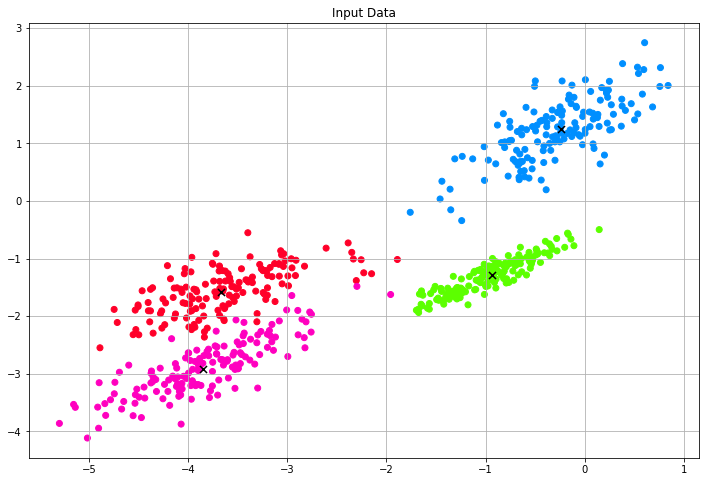

In [4]:
Clusters = 4
n = 150
d = 3
Epsilon = 1e-4
Data,Labels,TrueMean,TrueCoVariance = GenerateData(Clusters,n,d)

print ("True Mean:\n", TrueMean)
print()
print ("True CoVariance:\n", TrueCoVariance)

plt.figure(figsize=(12, 8))
plt.grid()
plt.title("Input Data")
plt.scatter(Data[:,0],Data[:,1],c=Labels,cmap='gist_rainbow')
plt.scatter(TrueMean[:,0],TrueMean[:,1],marker='x',color='black',s=50)
plt.show()

### Estimating Data

**Note:** Rerun the Code if got an **Error** or **Nan's**.\
Reasons:
1. All Means and CoVariances are initialized randomly and there is a change of getting Zero Determinent for CoVariance. Unlike K-Means, Means are not initialised from Data Points.
2. Data Generated itself along with their Means and CoVariances are also generated Randomly.
3. It is possible that no points are assigned to a Gaussian due to randomness initializations which leads to Zero CoVariance Matrix.

In [5]:
GMM = GaussianMixtureModel()
GMM.fit(Data,Clusters,Epsilon)

-----------------------------------Iteration-0-----------------------------------
Mean:
 [[0.4864 0.3151 0.6702]
 [0.2991 0.4138 0.222 ]
 [0.5803 0.7566 0.5533]
 [0.8343 0.7758 0.1486]]
CoVariance:
 [[[ 1.8249 -0.7823 -0.5433]
  [-0.7823  0.8683  0.8755]
  [-0.5433  0.8755  2.165 ]]

 [[ 2.0628  0.4558 -1.6687]
  [ 0.4558  4.7423 -1.476 ]
  [-1.6687 -1.476   3.7904]]

 [[10.2565  5.2379  3.8844]
  [ 5.2379  4.4614  1.2512]
  [ 3.8844  1.2512  4.5217]]

 [[ 1.2944 -1.8654  1.3674]
  [-1.8654  2.8243 -1.9339]
  [ 1.3674 -1.9339  1.5192]]]
Probabilities:
 [0.2383 0.2717 0.2567 0.2333]

-----------------------------------Iteration-1-----------------------------------
Mean:
 [[-0.6398 -0.6022 -3.2   ]
 [-2.4305 -0.8391  1.8944]
 [-2.3419 -1.5447 -0.5727]
 [-0.139   1.6883 -1.3336]]
CoVariance:
 [[[ 1.1120e-01  6.8400e-02  8.4100e-02]
  [ 6.8400e-02  6.9300e-01  6.4230e-01]
  [ 8.4100e-02  6.4230e-01  6.1140e-01]]

 [[ 2.5916e+00  2.0564e+00 -3.6714e+00]
  [ 2.0564e+00  2.0492e+00 -2.7889e+0

### At Convergence

In [6]:
PredictedMean, PredictedCoVariance, PredictedLabels = GMM.Parameters()
print ("Predicted Mean:\n", np.round(PredictedMean,decimals=4))
print ("Predicted CoVariance:\n", np.round(PredictedCoVariance,decimals=4))
print()
print ("True Mean:\n", TrueMean)
print ("True CoVariance:\n", TrueCoVariance)

Predicted Mean:
 [[-0.9498 -1.2913 -3.9535]
 [-3.6403 -1.5543  3.6826]
 [-3.8336 -2.8756  2.1904]
 [-0.2823  1.2261 -1.6667]]
Predicted CoVariance:
 [[[0.1607 0.117  0.1722]
  [0.117  0.1009 0.141 ]
  [0.1722 0.141  0.2002]]

 [[0.316  0.1433 0.1768]
  [0.1433 0.1579 0.0606]
  [0.1768 0.0606 0.1148]]

 [[0.3511 0.2454 0.4036]
  [0.2454 0.2459 0.323 ]
  [0.4036 0.323  0.5127]]

 [[0.249  0.1998 0.1269]
  [0.1998 0.2998 0.2059]
  [0.1269 0.2059 0.1507]]]

True Mean:
 [[-3.6681 -1.5799  3.6655]
 [-0.9324 -1.2934 -3.9473]
 [-0.2377  1.2475 -1.6505]
 [-3.8498 -2.9107  2.1545]]
True CoVariance:
 [[[0.3437 0.1404 0.2062]
  [0.1404 0.1449 0.0707]
  [0.2062 0.0707 0.138 ]]

 [[0.172  0.1205 0.18  ]
  [0.1205 0.1012 0.1424]
  [0.18   0.1424 0.2044]]

 [[0.2551 0.1943 0.118 ]
  [0.1943 0.2929 0.1968]
  [0.118  0.1968 0.1409]]

 [[0.3525 0.2628 0.4028]
  [0.2628 0.2815 0.3447]
  [0.4028 0.3447 0.508 ]]]


### Plotting Gaussian Mixtures
Plotting the first 2 Dimensions of each of the Samples and Means of Mixtures.

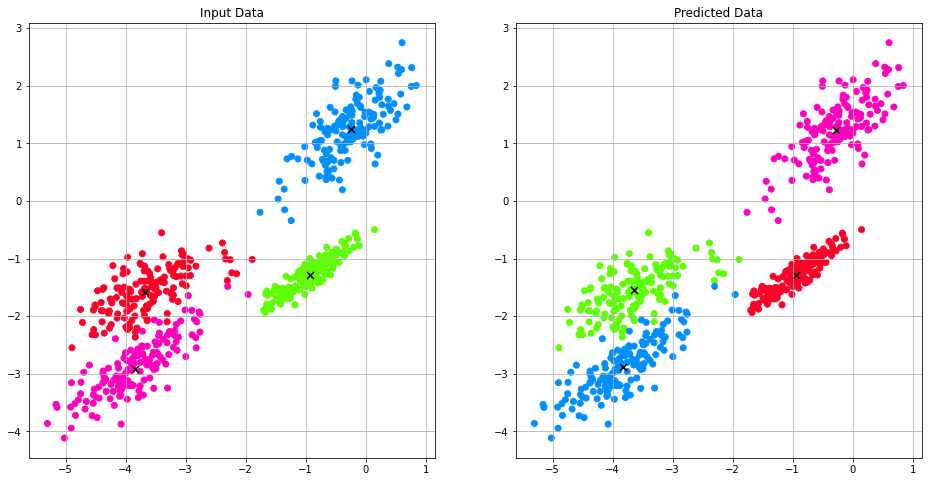

In [7]:
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.grid()
plt.title("Input Data")
plt.scatter(Data[:,0],Data[:,1],c=Labels,cmap='gist_rainbow')
plt.scatter(TrueMean[:,0],TrueMean[:,1],marker='x',color='black',s=50)

plt.subplot(1,2,2)
plt.grid()
plt.title("Predicted Data")
plt.scatter(Data[:,0],Data[:,1],c=PredictedLabels,cmap='gist_rainbow')
plt.scatter(PredictedMean[:,0],PredictedMean[:,1],marker='x',color='black',s=50)
plt.show()

### Plotting Means
Plotting the first 2 Dimensions of Means of Mixtures.

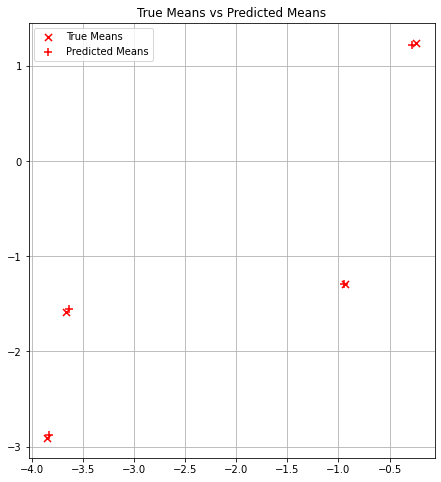

In [8]:
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.grid()
plt.title("True Means vs Predicted Means")
plt.scatter(TrueMean[:,0],TrueMean[:,1],marker='x',color='r',s=50,label="True Means")
plt.scatter(PredictedMean[:,0],PredictedMean[:,1],marker='+',color='r',s=50,label="Predicted Means")
plt.legend()
plt.show()